In [43]:
import numpy as np

from commstools import Signal
from commstools.impairments import apply_awgn, apply_pmd


In [44]:
NUM_SYMBOLS = 2**20
SYMBOL_RATE = 1e9
SPS = 2
MOD = "QAM"
ORDER = 64
ESN0_DB = 25
DGD_SYMBOLS = 10
THETA = np.pi / 4


,Property,Value
0,Spectral Domain,BASEBAND
1,Physical Domain,DIG
2,Modulation (Scheme/Order),QAM / 64
3,Symbol Rate,1.00 GBaud
4,Bit Rate,6.00 Gbps
5,Sampling Rate,2.00 GHz
6,Samples Per Symbol,2.00
7,Pulse Shape,RRC
8,Duration,1.05 ms
9,Center Frequency,0.00 Hz


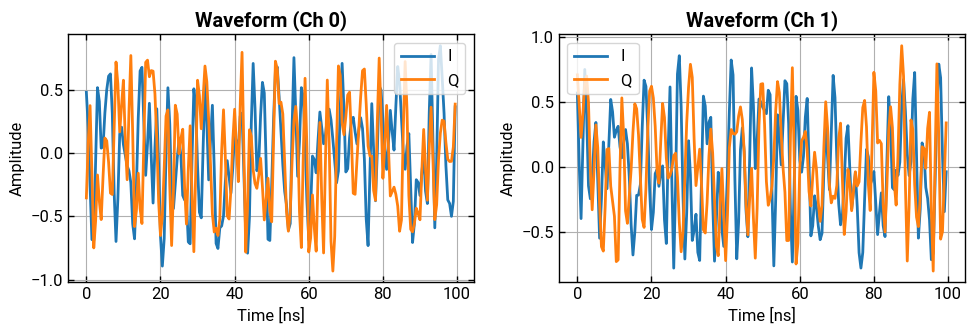

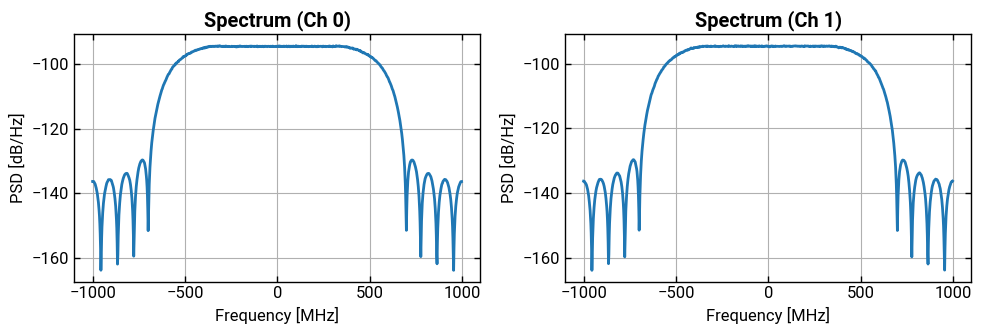

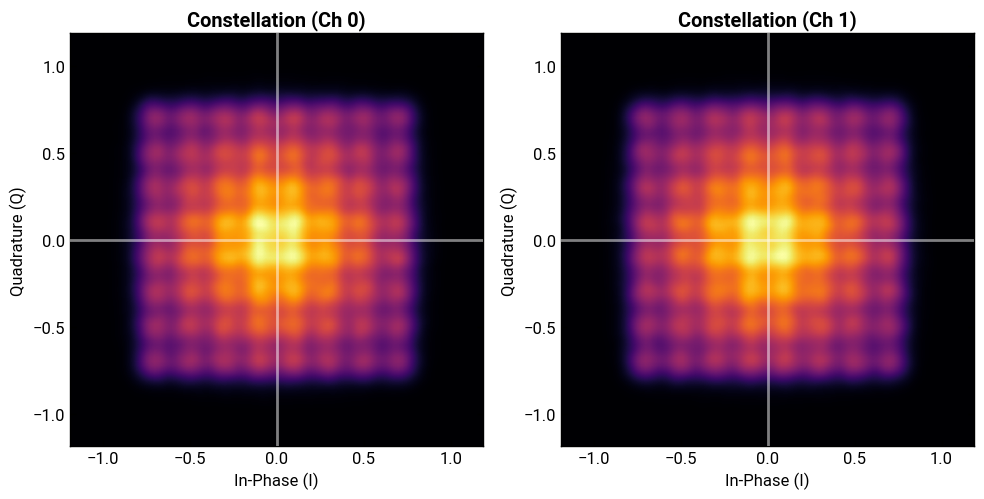

In [45]:
sig = Signal.qam(
    num_symbols=NUM_SYMBOLS,
    sps=SPS,
    symbol_rate=SYMBOL_RATE,
    order=ORDER,
    num_streams=2,
    seed=42,
)
sig.print_info()
sig.plot_waveform(num_symbols=100, show=True)
sig.plot_psd(show=True, nperseg=2**10)
sig.plot_constellation(show=True)


,Property,Value
0,Spectral Domain,BASEBAND
1,Physical Domain,DIG
2,Modulation (Scheme/Order),QAM / 64
3,Symbol Rate,1.00 GBaud
4,Bit Rate,6.00 Gbps
5,Sampling Rate,2.00 GHz
6,Samples Per Symbol,2.00
7,Pulse Shape,RRC
8,Duration,1.05 ms
9,Center Frequency,0.00 Hz


2026-02-24 15:19:49 [INFO] [commstools/impairments.py] Adding AWGN (Es/N0 target: 25.00 dB).


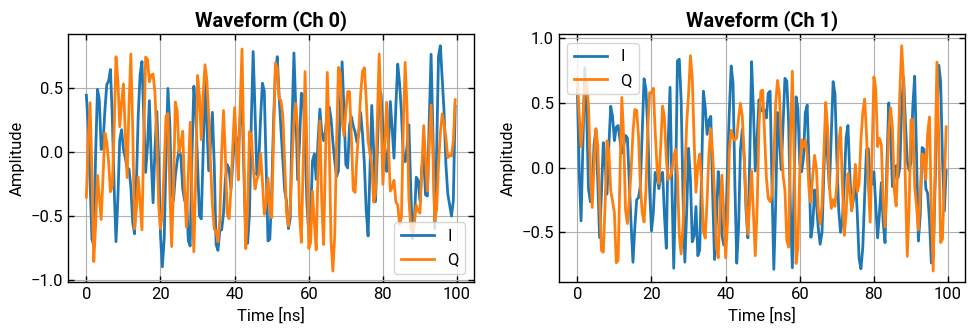

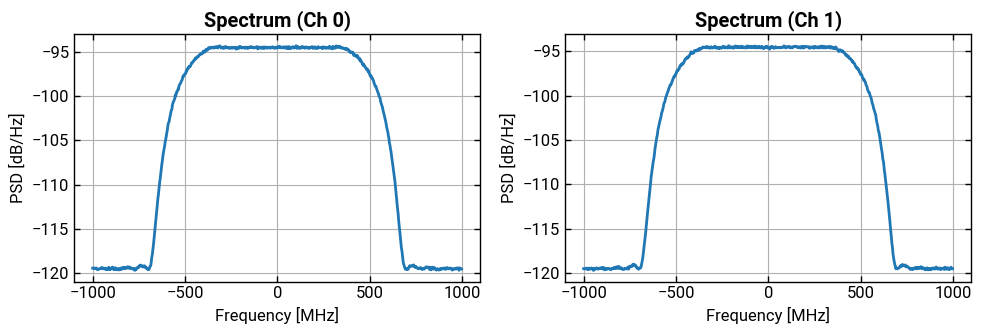

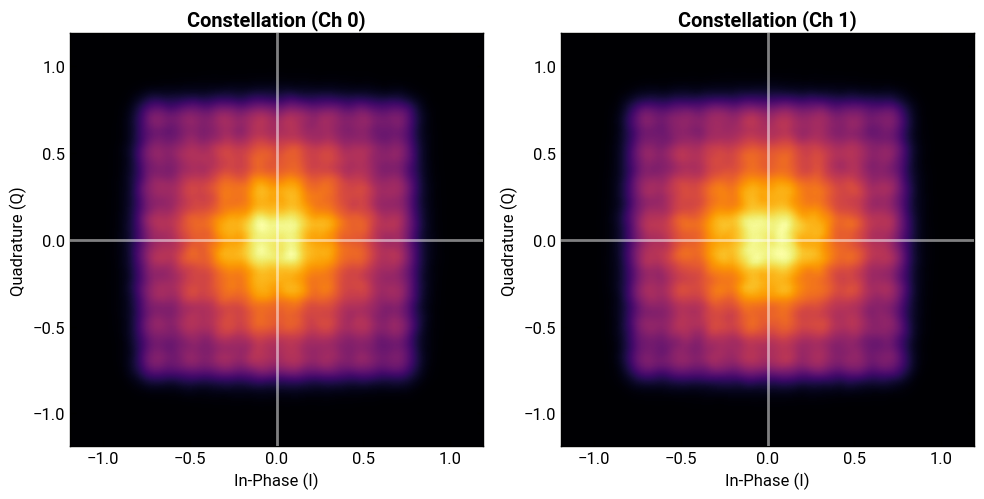

In [46]:
sig_dist = sig.copy()

sig_dist.print_info()
sig_dist = apply_awgn(sig_dist, esn0_db=ESN0_DB)
sig_dist.plot_waveform(num_symbols=100, show=True)
sig_dist.plot_psd(show=True, nperseg=2**10)
sig_dist.plot_constellation(show=True)


2026-02-24 15:19:50 [INFO] [commstools/impairments.py] Applying PMD (DGD=1.00e-08 s, theta=0.785 rad).


,Property,Value
0,Spectral Domain,BASEBAND
1,Physical Domain,DIG
2,Modulation (Scheme/Order),QAM / 64
3,Symbol Rate,1.00 GBaud
4,Bit Rate,6.00 Gbps
5,Sampling Rate,2.00 GHz
6,Samples Per Symbol,2.00
7,Pulse Shape,RRC
8,Duration,1.05 ms
9,Center Frequency,0.00 Hz


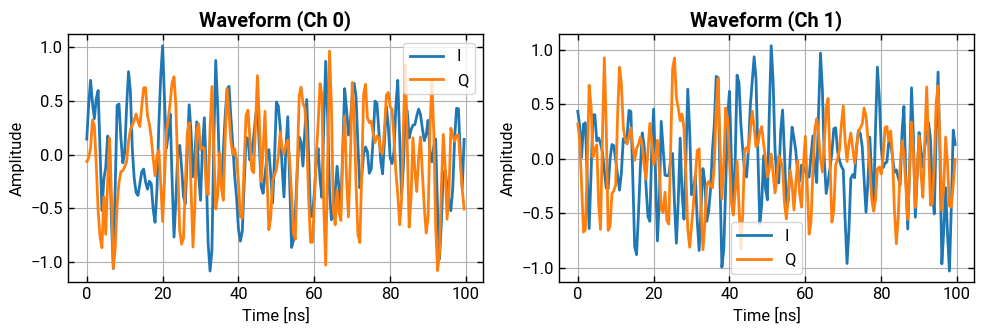

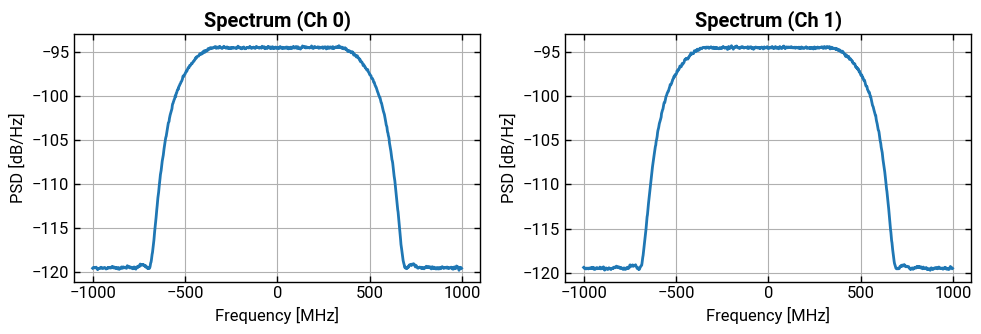

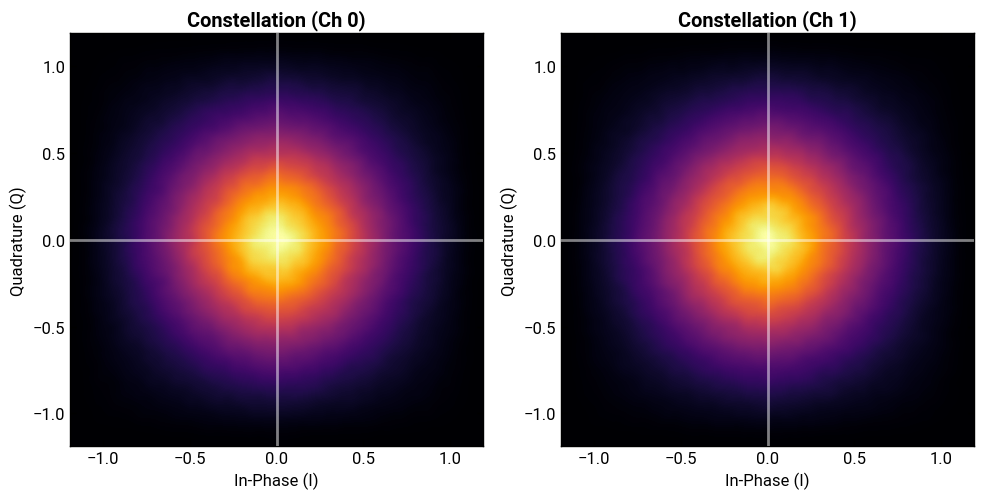

In [47]:
sig_dist = apply_pmd(sig_dist, dgd=DGD_SYMBOLS / SYMBOL_RATE, theta=THETA)

sig_dist.print_info()
sig_dist.plot_waveform(num_symbols=100, show=True)
sig_dist.plot_psd(show=True, nperseg=2**10)
sig_dist.plot_constellation(show=True)


2026-02-24 15:19:52 [INFO] [commstools/core.py] Generating shaping filter taps (shape: rrc).


,Property,Value
0,Spectral Domain,BASEBAND
1,Physical Domain,DIG
2,Modulation (Scheme/Order),QAM / 64
3,Symbol Rate,1.00 GBaud
4,Bit Rate,6.00 Gbps
5,Sampling Rate,2.00 GHz
6,Samples Per Symbol,2.00
7,Pulse Shape,RRC
8,Duration,1.05 ms
9,Center Frequency,0.00 Hz


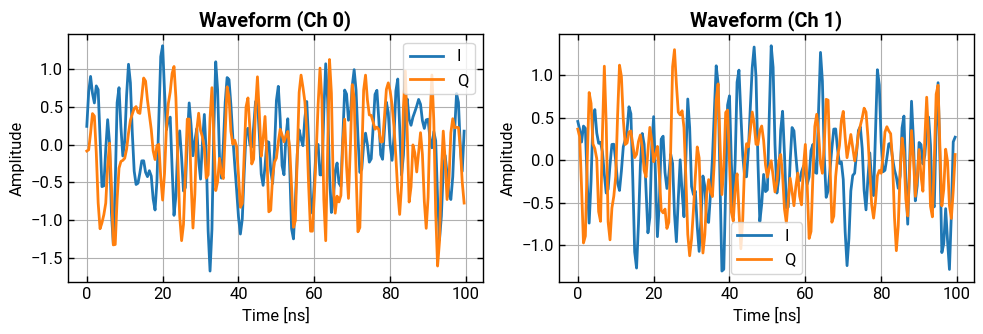

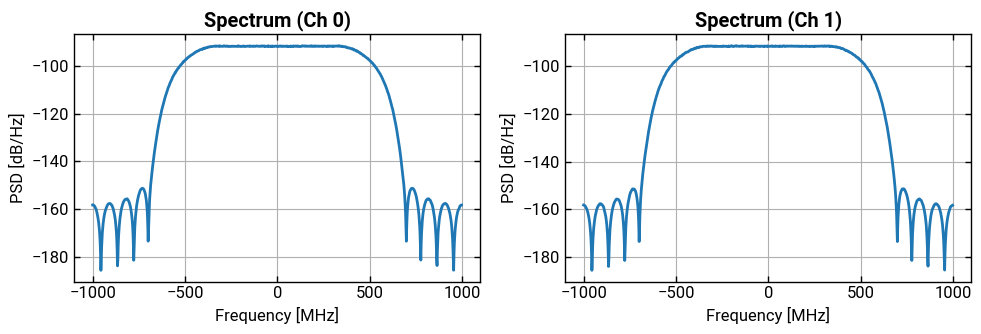

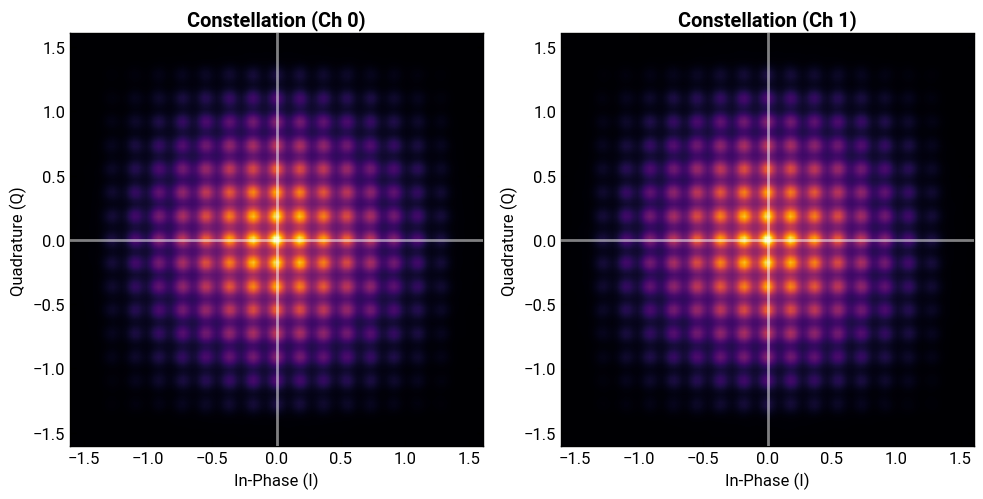

In [48]:
sig_dist.matched_filter()

sig_dist.print_info()
sig_dist.plot_waveform(num_symbols=100, show=True)
sig_dist.plot_psd(show=True, nperseg=2**10)
sig_dist.plot_constellation(show=True)


In [49]:
sig_to_eq = sig_dist.copy()
# sig_to_eq.decimate_to_symbol_rate()
sig_to_eq.print_info()

sig_to_eq.equalize(
    method="rls",
    # step_size=0.1,
    num_train_symbols=2**12,
    # forgetting_factor=0.999,
    # delta=1.0,
    # leakage=0.0,
    num_taps=11,
    backend="numba",
)
sig_to_eq.plot_equalizer(show=True, smoothing=100)

sig_to_eq.plot_waveform(num_symbols=99, show=True)
sig_to_eq.plot_constellation(show=True)
sig_to_eq.resolve_symbols()
sig_to_eq.evm()


,Property,Value
0,Spectral Domain,BASEBAND
1,Physical Domain,DIG
2,Modulation (Scheme/Order),QAM / 64
3,Symbol Rate,1.00 GBaud
4,Bit Rate,6.00 Gbps
5,Sampling Rate,2.00 GHz
6,Samples Per Symbol,2.00
7,Pulse Shape,RRC
8,Duration,1.05 ms
9,Center Frequency,0.00 Hz


2026-02-24 15:19:53 [WARNING] [commstools/equalizers.py] RLS is mathematically ill-conditioned for fractionally-spaced signals (sps=2). The noise-only null-subspace creates a singular correlation matrix, causing tap bloat. Use LMS for fractionally-spaced equalization unless heavy Tikhonov regularization is applied.
2026-02-24 15:19:53 [INFO] [commstools/equalizers.py] RLS equalizer: num_taps=11, lambda=0.99, delta=1.00e-02, leakage=0.00e+00, sps=2, backend=numba, num_train_symbols=4096


ZeroDivisionError: division by zero

In [ ]:
sig_to_eq.demap_symbols_hard()
sig_to_eq.ber()


2026-02-24 14:38:20 [INFO] [commstools/core.py] Discarding 1024 training symbols for BER calculation.
2026-02-24 14:38:20 [INFO] [commstools/metrics.py] BER Ch0: 2.94e-05 (183/6224960 errors)
2026-02-24 14:38:20 [INFO] [commstools/metrics.py] BER Ch1: 2.55e-05 (159/6224960 errors)


array([2.93977793e-05, 2.55423328e-05])

In [ ]:
sig_to_eq.source_symbols


array([[ 0.77184427-0.46310657j, -0.46310657+0.46310657j,
        -1.0805819 -1.0805819j , ...,  0.77184427-0.46310657j,
         0.15436886-1.0805819j , -0.15436886-0.77184427j],
       [ 0.7716346 +1.0802884j , -0.46298075+0.46298075j,
         1.0802884 +1.0802884j , ..., -0.15432692-1.0802884j ,
        -1.0802884 +0.15432692j,  0.7716346 +1.0802884j ]],
      shape=(2, 1048576), dtype=complex64)

In [ ]:
51 // 2


25

In [ ]:
for i in range(0, 13):
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12


In [ ]:
13 // 2


6